# Dynamic Time Warping

### Calculate DTW similarity measure of two time series

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from tslearn.metrics import dtw

from scipy.spatial.distance import cdist

%run ../utilities/dtw_utils.py

## Import time series

####    &emsp;- Separate time series by strain
####    &emsp;- Filter genes that don't exceed 20 TPM at any time point for each strain's time series

In [3]:
ts = pd.read_csv("../_data/in_vitro/TPMs/TPMs.csv").rename(columns = {'Unnamed: 0':'ORF'}).set_index('ORF')
ts_3D7 = ts.iloc[:,:64].copy()
ts_FUP = ts.iloc[:,64:128].copy()

ts_3D7 = ts_3D7[(ts_3D7 > 20).any(1)]
ts_FUP = ts_FUP[(ts_FUP > 20).any(1)]

idx_3D7 = list(ts_3D7.index)
idx_FUP = list(ts_FUP.index)

time_points = list(range(3, 51, 3))

### Split the time series by individual isolate

In [12]:
geneSet = idx_3D7
AA13_3D7_dtw = getGenes(ts, '(AA13.*3D7)', geneSet)
AA17_3D7_dtw = getGenes(ts, '(AA17.*3D7)', geneSet)
AS15_3D7_dtw = getGenes(ts, '(AS15.*3D7)', geneSet)
AS16_3D7_dtw = getGenes(ts, '(AS16.*3D7)', geneSet)

geneSet = idx_FUP
AA13_FUP_dtw = getGenes(ts, '(AA13.*FUP)', geneSet)
AA17_FUP_dtw = getGenes(ts, '(AA17.*FUP)', geneSet)
AS18_FUP_dtw = getGenes(ts, '(AS18.*FUP)', geneSet)
AS19_FUP_dtw = getGenes(ts, '(AS19.*FUP)', geneSet)

#### If DTW has already been calculated and results have been merged, read in .csv file for each strain to DataFrame

In [4]:
dtw_3D7 = pd.read_csv("../_data/in_vitro/DTW_scores/3D7_DTW.csv", index_col="ORF")
dtw_FUP = pd.read_csv("../_data/in_vitro/DTW_scores/FUP_DTW.csv", index_col="ORF")

### Calculate Dynamic Time Warping scores for each pairwise comparison

In [21]:
AA13vAA17_3D7 = dtw_df(AA13_3D7_dtw, AA17_3D7_dtw, time_points, "AA13vAA17_3D7")
AA13vAS15_3D7 = dtw_df(AA13_3D7_dtw, AS15_3D7_dtw, time_points, "AA13vAS15_3D7")
AA13vAS16_3D7 = dtw_df(AA13_3D7_dtw, AS16_3D7_dtw, time_points, "AA13vAS16_3D7")
AA17vAS15_3D7 = dtw_df(AA17_3D7_dtw, AS15_3D7_dtw, time_points, "AA17vAS15_3D7")
AA17vAS16_3D7 = dtw_df(AA17_3D7_dtw, AS16_3D7_dtw, time_points, "AA17vAS16_3D7")
AS15vAS16_3D7 = dtw_df(AS15_3D7_dtw, AS16_3D7_dtw, time_points, "AS15vAS16_3D7")

AA13vAA17_FUP = dtw_df(AA13_FUP_dtw, AA17_FUP_dtw, time_points, "AA13vAA17_FUP")
AA13vAS18_FUP = dtw_df(AA13_FUP_dtw, AS18_FUP_dtw, time_points, "AA13vAS18_FUP")
AA13vAS19_FUP = dtw_df(AA13_FUP_dtw, AS19_FUP_dtw, time_points, "AA13vAS19_FUP")
AA17vAS18_FUP = dtw_df(AA17_FUP_dtw, AS18_FUP_dtw, time_points, "AA17vAS18_FUP")
AA17vAS19_FUP = dtw_df(AA17_FUP_dtw, AS19_FUP_dtw, time_points, "AA17vAS19_FUP")
AS18vAS19_FUP = dtw_df(AS18_FUP_dtw, AS19_FUP_dtw, time_points, "AS18vAS19_FUP")

### Merge DTW results from each comparison into one table for each parasite strain

#### &emsp; -Calculate mean DTW score of AAvAS comparisons and save in new column of DataFrame

#### &emsp; -Write results to .csv file

In [58]:
if dtw_3D7.empty:
    dtw_3D7 = AA13vAA17_3D7.merge(AA13vAS15_3D7[['AA13vAS15_3D7']], left_index=True, right_index=True, how='inner')
    dtw_3D7 = dtw_3D7.merge(AA13vAS16_3D7[['AA13vAS16_3D7']], left_index=True, right_index=True, how='inner')
    dtw_3D7 = dtw_3D7.merge(AA17vAS15_3D7[['AA17vAS15_3D7']], left_index=True, right_index=True, how='inner')
    dtw_3D7 = dtw_3D7.merge(AA17vAS16_3D7[['AA17vAS16_3D7']], left_index=True, right_index=True, how='inner')
    dtw_3D7 = dtw_3D7.merge(AS15vAS16_3D7[['AS15vAS16_3D7']], left_index=True, right_index=True, how='inner')
    dtw_3D7['AAvAS_mean'] = dtw_3D7[['AA13vAS15_3D7', 'AA13vAS16_3D7', 'AA17vAS15_3D7', 'AA17vAS16_3D7']].mean(axis=1)
    dtw_3D7 = dtw_3D7.sort_values(by='AAvAS_mean', ascending = True)
if dtw_FUP.empty:
    dtw_FUP = AA13vAA17_FUP.merge(AA13vAS18_FUP[['AA13vAS18_FUP']], left_index=True, right_index=True, how='inner')
    dtw_FUP = dtw_FUP.merge(AA13vAS19_FUP[['AA13vAS19_FUP']], left_index=True, right_index=True, how='inner')
    dtw_FUP = dtw_FUP.merge(AA17vAS18_FUP[['AA17vAS18_FUP']], left_index=True, right_index=True, how='inner')
    dtw_FUP = dtw_FUP.merge(AA17vAS19_FUP[['AA17vAS19_FUP']], left_index=True, right_index=True, how='inner')
    dtw_FUP = dtw_FUP.merge(AS18vAS19_FUP[['AS18vAS19_FUP']], left_index=True, right_index=True, how='inner')
    dtw_FUP['AAvAS_mean'] = dtw_FUP[['AA13vAS18_FUP', 'AA13vAS19_FUP', 'AA17vAS18_FUP', 'AA17vAS19_FUP']].mean(axis=1)
    dtw_FUP = dtw_FUP.sort_values(by='AAvAS_mean', ascending = True)

### Make density plot of DTW scores for all comparisons

Text(0.5, 1.0, 'DTW Scores - 3D7 isolates')

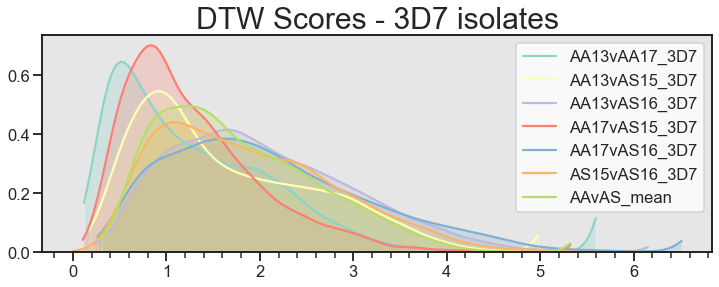

In [5]:
sns.set_palette("Set3")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": '.9', 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(12,4))
data = dtw_3D7
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='white')
plt.title('DTW Scores - 3D7 isolates', fontsize=30)

In [6]:
dtw_3D7_names = dtw_3D7.rename(columns = {'AA13vAA17_3D7':'HbAA1vHbAA2', 'AA13vAS15_3D7':'HbAA1vHbAS1', 
                                          'AA13vAS16_3D7':'HbAA1vHbAS2', 'AA17vAS15_3D7':'HbAA2vHbAS1', 
                                          'AA17vAS16_3D7':'HbAA2vHbAS2', 'AS15vAS16_3D7':'HbAS1vHbAS2', 
                                         'AAvAS_mean':'HbAAvHbAS mean'})

## Draw ridgeplot of 3D7 DTW scores

/Users/joe/miniconda3/envs/main/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/Users/joe/miniconda3/envs/main/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


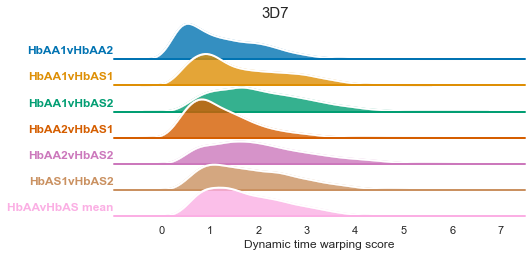

In [7]:
df_3D7 = dtw_3D7_names.reset_index()
df_3D7 = df_3D7.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')
g = ridgeplot(df_3D7, "3D7")

### Summarize the central tendency, dispersion and shape of the 3D7 DTW dataset

In [8]:
stats_3D7 = dtw_3D7.describe()
stats_3D7

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
count,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4.048000e+03,4048.000000
mean,1.245301,1.637448,2.041717,1.281251,2.079203,1.885151e+00,1.759905
std,0.800327,0.938294,0.964572,0.722417,1.066615,9.325780e-01,0.832606
min,0.119090,0.176446,0.232816,0.103595,0.263622,4.933939e-16,0.309468
25%,0.563672,0.880039,1.285413,0.755215,1.269892,1.120601e+00,1.094928
50%,1.050951,1.375962,1.900305,1.109329,1.907430,1.748729e+00,1.597425
75%,1.816043,2.328713,2.675165,1.663365,2.732381,2.505142e+00,2.318455
max,5.595590,4.979727,6.151226,5.323310,6.512863,6.045640e+00,5.323417


In [9]:
thresh_3D7 = (dtw_3D7['AAvAS_mean'].std() * 2) + dtw_3D7['AAvAS_mean'].mean()
print(thresh_3D7)

3.425116375983496


### Identify genes with the highest DTW scores HbAAvHbAS in 3D7

In [10]:
sigDTW_3D7 = dtw_3D7[(dtw_3D7['AAvAS_mean'] > thresh_3D7)]
sigDTW_3D7.sort_values(by = 'AAvAS_mean', ascending=False)

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
ORF,,,,,,,
PF3D7_0108300,3.532169,3.996181,5.682507,5.323310,6.291670,4.557548,5.323417
PF3D7_0113400,2.656812,4.829321,5.545535,4.912220,5.953893,2.509563,5.310242
PF3D7_1216900,2.129506,4.345257,5.115797,3.341273,5.689006,4.248782,4.622833
PF3D7_1477600,2.589815,3.805124,4.709185,4.331614,5.626432,2.393392,4.618089
PF3D7_1109900,4.655873,4.731100,2.660115,5.019669,5.590026,3.526149,4.500227
...,...,...,...,...,...,...,...
PF3D7_0822300,3.005155,3.077364,3.231082,2.957157,4.445656,4.259850,3.427814
PF3D7_0403300,3.666950,4.310023,3.486594,1.913351,3.998120,3.224308,3.427022
PF3D7_0310200,2.638523,2.560247,3.851219,2.495387,4.799018,3.695670,3.426468


### Plot gene expression and warping path on heatmap for a gene of interest's time series

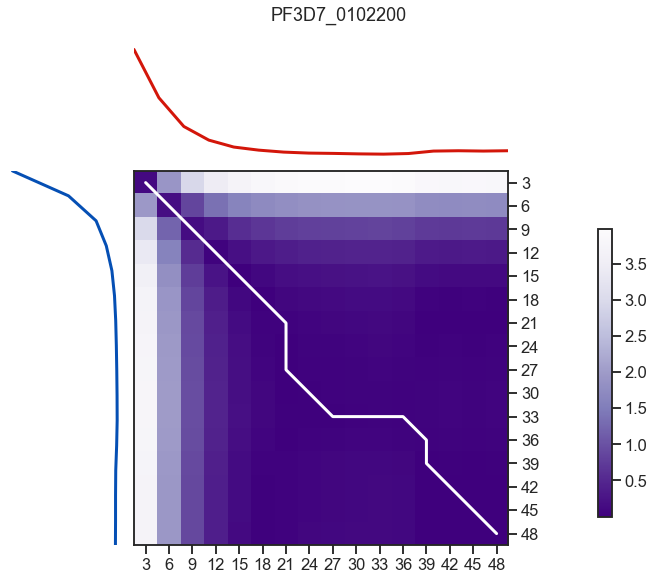

In [13]:
orf = 'PF3D7_0102200'
pathmap(AA17_3D7_dtw, AS15_3D7_dtw, orf, time_points)

Text(0.5, 1.0, 'DTW Scores - FUP isolates')

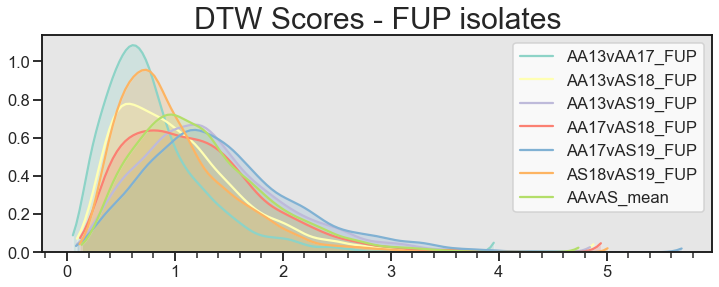

In [14]:
sns.set_palette("Set3")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": ".9", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(12,4))
data = dtw_FUP
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='white')
plt.title('DTW Scores - FUP isolates', fontsize=30)

In [15]:
dtw_FUP_names = dtw_FUP.rename(columns = {'AA13vAA17_FUP':'HbAA1vHbAA2', 'AA13vAS18_FUP':'HbAA1vHbAS1', 
                                          'AA13vAS19_FUP':'HbAA1vHbAS2', 'AA17vAS18_FUP':'HbAA2vHbAS1', 
                                          'AA17vAS19_FUP':'HbAA2vHbAS2', 'AS18vAS19_FUP':'HbAS1vHbAS2', 
                                         'AAvAS_mean':'HbAAvHbAS mean'})

## Draw ridgeplot of FUP DTW scores

/Users/joe/miniconda3/envs/main/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/Users/joe/miniconda3/envs/main/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


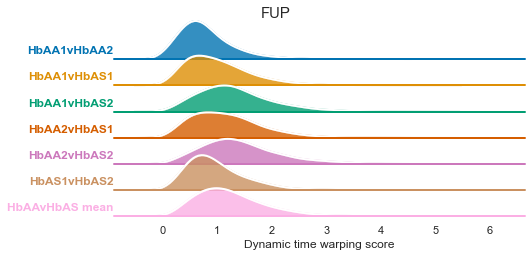

In [16]:
df_FUP = dtw_FUP_names.reset_index()
df_FUP = df_FUP.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')
g = ridgeplot(df_FUP, "FUP")

### Summarize the central tendency, dispersion and shape of the FUP DTW dataset

In [14]:
stats_FUP = dtw_FUP.describe()
stats_FUP

,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean
count,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000
mean,0.794465,1.026128,1.327843,1.176767,1.431966,0.989047,1.240676
std,0.479035,0.583268,0.673412,0.633218,0.717808,0.533002,0.611227
min,0.053819,0.091133,0.089881,0.120910,0.082916,0.115292,0.135178
25%,0.467247,0.575809,0.855179,0.695300,0.927667,0.609200,0.790898
50%,0.696506,0.919158,1.232192,1.090065,1.323049,0.866966,1.143744
75%,1.011373,1.339888,1.684692,1.528646,1.800200,1.243782,1.583688
max,3.953836,4.878316,4.845913,4.946421,5.694593,5.008385,4.738482


In [19]:
thresh_FUP = (dtw_FUP['AAvAS_mean'].std() * 2) + dtw_FUP['AAvAS_mean'].mean()
thresh_FUP

2.4631296506102442

### Identify genes with the highest DTW scores HbAAvHbAS in FUP

In [20]:
sigDTW_FUP = dtw_FUP[(dtw_FUP['AAvAS_mean'] > thresh_FUP)]
sigDTW_FUP.sort_values(by = 'AAvAS_mean', ascending=False)

,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean
ORF,,,,,,,
PF3D7_1002500,1.872893,4.853448,4.845913,4.715337,4.539231,2.336559,4.738482
PF3D7_1103900,3.098880,3.704685,4.533161,4.876479,5.694593,3.589849,4.702230
PF3D7_0206600,1.094027,4.878316,4.394422,4.654751,4.326795,2.827257,4.563571
PF3D7_0212200,1.777271,3.722635,4.820086,3.947716,4.755689,2.395729,4.311531
PF3D7_0702600,1.936870,4.743038,3.423752,4.946421,3.258694,2.533079,4.092976
...,...,...,...,...,...,...,...
PF3D7_0919700,1.100150,2.175722,2.601955,2.389215,2.730684,1.057044,2.474394
PF3D7_0707600,2.271528,1.925204,2.935810,2.332032,2.703360,2.169540,2.474102
PF3D7_0219100,1.353522,1.981777,2.485469,2.522245,2.887207,1.132738,2.469175


### Plot gene expression and warping path on heatmap for a gene of interest's time series

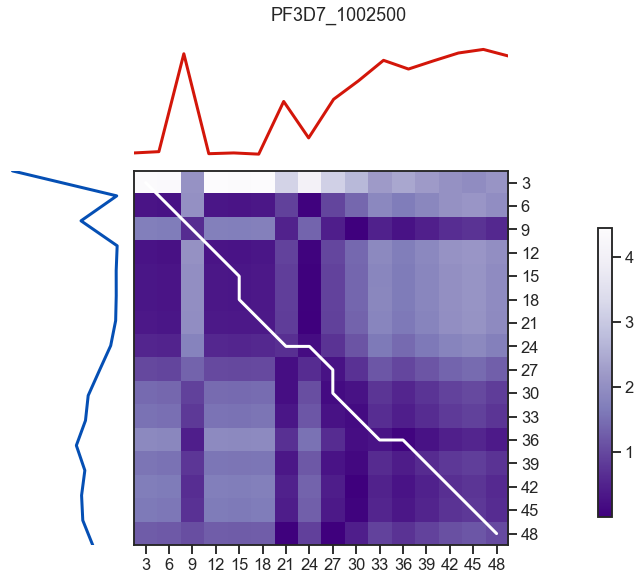

In [21]:
orf = 'PF3D7_1002500'
pathmap(AA13_FUP_dtw, AS18_FUP_dtw, orf, time_points)

# Plot heatmaps of significant DTW transcripts

In [28]:
%run ../utilities/utilities.py

In [26]:
mean_data_df = pd.read_csv("../_data/in_vitro/Read_counts/TPMs_rep_means.csv", index_col=0)
time_points = list(range(3, 51,3))

AA_3D7_df, AS_3D7_df = get_ts_mean('3D7')
AA_FUP_df, AS_FUP_df = get_ts_mean('FUP')

dtw_3D7_transcripts = dtw_3D7.index.tolist()
dtw_FUP_transcripts = dtw_FUP.index.tolist()

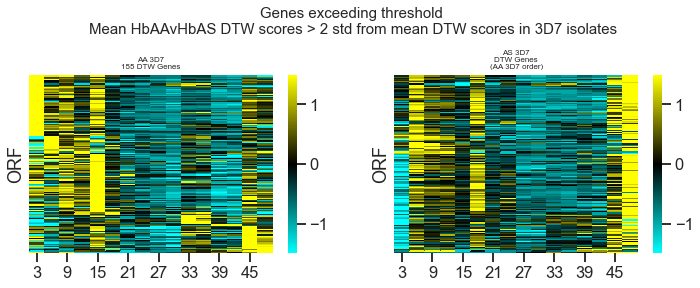

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
fig.suptitle('Genes exceeding threshold \nMean HbAAvHbAS DTW scores > 2 std from mean DTW scores in 3D7 isolates', fontsize=15)
AA_3D7_heat = heatmap_max(AA_3D7_df, sigDTW_3D7.index.tolist(), 16, axis=ax1, yticks=False)
ax1.set_title('AA 3D7\n{} DTW Genes'.format(len(sigDTW_3D7.index.tolist())), fontsize=8)
AS_3D7_heat = heatmap_order(AS_3D7_df, AA_3D7_heat.tolist(), axis=ax2)
ax2.set_title('AS 3D7\nDTW Genes\n(AA 3D7 order)', fontsize=8)
plt.subplots_adjust(top=0.745)

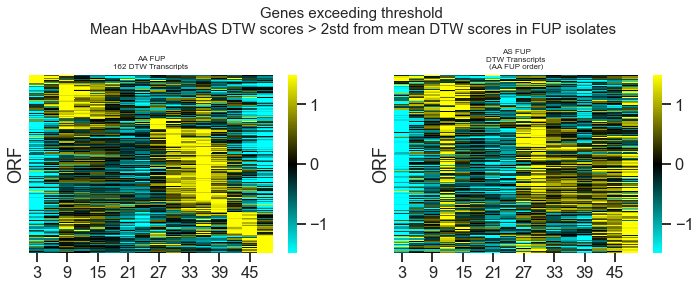

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
fig.suptitle('Genes exceeding threshold \nMean HbAAvHbAS DTW scores > 2std from mean DTW scores in FUP isolates', fontsize=15)
AA_FUP_heat = heatmap_max(AA_FUP_df, sigDTW_FUP.index.tolist(), 16, axis=ax1, yticks=False)
ax1.set_title('AA FUP\n{} DTW Transcripts'.format(len(sigDTW_FUP.index.tolist())), fontsize=8)
AS_FUP_heat = heatmap_order(AS_FUP_df, AA_FUP_heat.tolist(), axis=ax2)
ax2.set_title('AS FUP\nDTW Transcripts\n(AA FUP order)', fontsize=8)
plt.subplots_adjust(top=0.745)

# Explore functional associated with temporally dysregulated transcripts

In [31]:
dtw_scores = dtw_3D7.merge(dtw_FUP, left_index=True, right_index=True, how='inner')
dtw_scores = dtw_scores.rename(columns = {'AAvAS_mean_x' : 'AAvAS_mean_3D7', 'AAvAS_mean_y' : 'AAvAS_mean_FUP'})

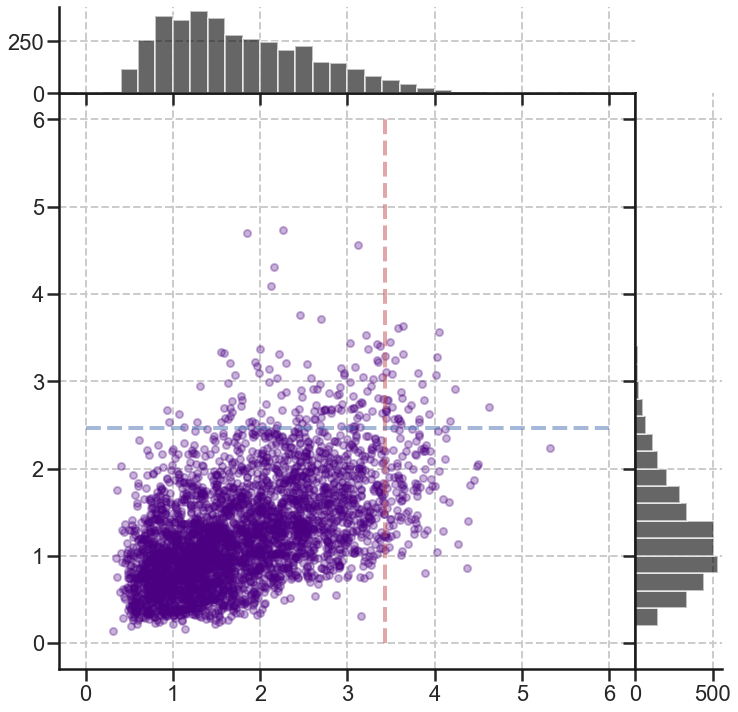

In [32]:
sns.set_style("whitegrid", {"axes.facecolor": "1", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True, 'grid.linestyle': '--'} )
sns.set_context("poster")

# Fixing random state for reproducibility
np.random.seed(19680801)

x = dtw_scores['AAvAS_mean_3D7']
y = dtw_scores['AAvAS_mean_FUP']

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color = "indigo", alpha =0.3, s = 50)
    
    # determine limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color="black", alpha=.6)
    ax_histy.hist(y, bins=bins, orientation='horizontal', color="black", alpha=.6)
    
# definitions for the axes
left, width = 0.1, 1
bottom, height = 0.1, 1
spacing = 0.00

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.15, height]

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
sns.despine(ax=ax_histx)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

sns.despine(ax=ax_histy)
# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

ax.plot([thresh_3D7, thresh_3D7], [0, 6], linewidth=4, color='r', alpha=.5, linestyle='dashed')
ax.plot([0, 6], [thresh_FUP, thresh_FUP], linewidth=4, color='b', alpha=.5, linestyle='dashed')

plt.show()

In [33]:
x = dtw_scores['AAvAS_mean_3D7'].to_numpy()
y = dtw_scores['AAvAS_mean_FUP'].to_numpy()
print("Spearman: ") 
print(scipy.stats.spearmanr(x, y))
print("Pearson: ") 
print(scipy.stats.pearsonr(x, y))

Spearman: 
SpearmanrResult(correlation=0.5516201229650746, pvalue=7.132523173812818e-298)
Pearson: 
(0.5429930006928265, 6.945038928695995e-287)


In [34]:
GeneID2nt_pfal_df = pd.read_csv('../_data/Annotations/ProteinTable33_369845.txt', sep='\t', header = 0)
GeneID2nt_pfal = GeneID2nt_pfal_df.set_index("GeneID")['Locus tag'].to_dict()
geneIDsGO = pd.read_csv("../_data/Annotations/Pfal_gene2go.csv")
annos = pd.read_csv("../_data/Annotations/PFD3D7_annos.csv")
annos = annos.set_index('Unnamed: 0')

In [35]:
dtw_scores = dtw_scores.reset_index()
data = dtw_scores.merge(
    GeneID2nt_pfal_df, 
    left_on='ORF', 
    right_on = 'Locus tag', 
    how='inner')
data['GeneID'] = data['GeneID'].astype(int)

In [36]:
data_GO = data.merge(geneIDsGO, left_on='GeneID', right_on='GeneID', how = 'inner')
data_GO['3D7_mean_GO'] = data_GO.groupby(['GO_term'])['AAvAS_mean_3D7'].transform('mean')
data_GO['FUP_mean_GO'] = data_GO.groupby(['GO_term'])['AAvAS_mean_FUP'].transform('mean')
df = data_GO['GO_term'].value_counts().rename_axis('GO_term').reset_index(name='Number of transcripts')
data_GO = data_GO.merge(df, left_on = 'GO_term', right_on='GO_term', how='left')

In [37]:
data_GO_mini = data_GO[['ORF', 'AAvAS_mean_3D7', 'AAvAS_mean_FUP', '3D7_mean_GO', 'FUP_mean_GO', 'GO_term', 'Number of transcripts', 'Category']]
df = data_GO_mini[(data_GO_mini['AAvAS_mean_3D7'] > thresh_3D7) | (data_GO_mini['AAvAS_mean_FUP'] > thresh_FUP)]['GO_term'].value_counts().rename_axis('GO_term').reset_index(name='Number of transcripts above threshold')
data_GO_mini = df.merge(data_GO_mini, left_on='GO_term', right_on='GO_term', how='right')
data_GO_mini['Number of transcripts above threshold'] = data_GO_mini['Number of transcripts above threshold'].fillna(0)
data_GO_mini['Proportion of GO term above DTW threshold'] = data_GO_mini['Number of transcripts above threshold']/data_GO_mini['Number of transcripts']
data_GO_mini = data_GO_mini.merge(annos, left_on='ORF', right_on='ORF')

In [38]:
BP = data_GO_mini[(data_GO_mini['Number of transcripts'] > 5) & (data_GO_mini['Category'] == 'Process')]
CC = data_GO_mini[(data_GO_mini['Number of transcripts'] > 5) & (data_GO_mini['Category'] == 'Component')]
MF = data_GO_mini[(data_GO_mini['Number of transcripts'] > 5) & (data_GO_mini['Category'] == 'Function')]

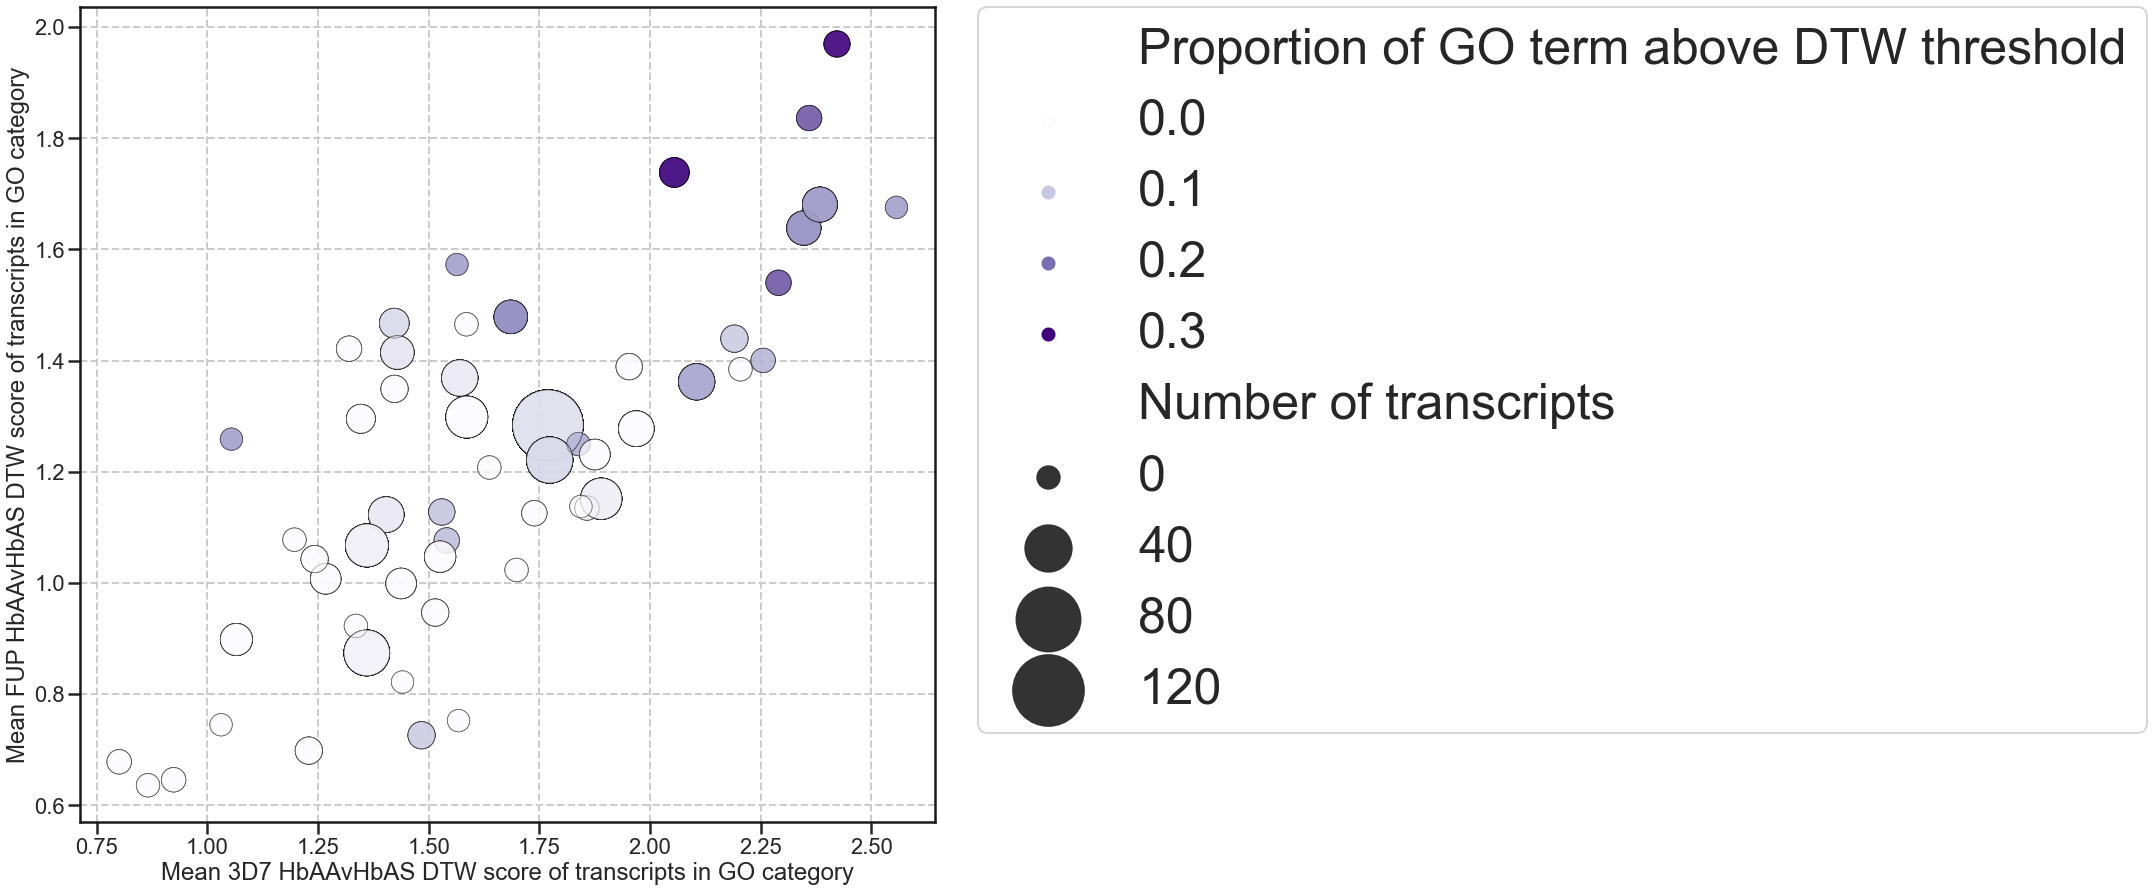

In [39]:
GO_cat = BP
sns.set_style("whitegrid", {"axes.facecolor": "1", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True, 'grid.linestyle': '--'} )
sns.set_context('poster')
plt.figure(figsize=(25,15))
ax = sns.scatterplot(x="3D7_mean_GO", y="FUP_mean_GO", data=GO_cat, 
                     size = 'Number of transcripts', edgecolor='black', sizes= (500,5000),
                     hue='Proportion of GO term above DTW threshold', palette = 'Purples', legend='brief', alpha=.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 50})
# plt.xlim(0.5,2.7)
# plt.ylim(0.5,2)
plt.xlabel("Mean 3D7 HbAAvHbAS DTW score of transcripts in GO category")
plt.ylabel("Mean FUP HbAAvHbAS DTW score of transcripts in GO category")
plt.gcf().subplots_adjust(right=.6)

In [20]:
calcCorr(BP['3D7_mean_GO'], BP['FUP_mean_GO'], "Biological Process GO term DTW score correlations: 3D7 vs FUP")
calcCorr(CC['3D7_mean_GO'], CC['FUP_mean_GO'], "Cellular Component GO term DTW score correlations: 3D7 vs FUP")
calcCorr(MF['3D7_mean_GO'], MF['FUP_mean_GO'], "Molecular Function GO term DTW score correlations: 3D7 vs FUP")

Spearman and Pearson correlations for Biological Process GO term DTW score correlations: 3D7 vs FUP
SpearmanrResult(correlation=0.6494846743769664, pvalue=4.4001896204860655e-101)
Pearson: (0.7591052224219159, 2.7711000437622366e-157)

Spearman and Pearson correlations for Cellular Component GO term DTW score correlations: 3D7 vs FUP
SpearmanrResult(correlation=0.6779441441706506, pvalue=2.908963066090641e-188)
Pearson: (0.7870622312993015, 2.437448093611144e-294)

Spearman and Pearson correlations for Molecular Function GO term DTW score correlations: 3D7 vs FUP
SpearmanrResult(correlation=0.3553019322082054, pvalue=2.77256252137811e-27)
Pearson: (0.5897879499747685, 1.224032699628381e-82)



In [21]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
from matplotlib import pyplot
from scipy import stats
from scipy.stats import normaltest

In [22]:
def testNormality(data, description):
    stat, p = normaltest(data)
    print('Data: {}'.format(description))
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('{} look Gaussian (fail to reject H0)'.format(description))
    else:
        print('{} do not look Gaussian (reject H0)\n'.format(description))

In [23]:
# Prepare 3D7 data
data_3D7_AAvAA = dtw_scores['AA13vAA17_3D7'].to_numpy()
data_3D7_ASvAA = dtw_scores['AAvAS_mean_3D7'].to_numpy()
data_3D7_AA13vAS15 = dtw_scores['AA13vAS15_3D7'].to_numpy()
data_3D7_AA13vAS16 = dtw_scores['AA13vAS16_3D7'].to_numpy()
data_3D7_AA17vAS15 = dtw_scores['AA17vAS15_3D7'].to_numpy()
data_3D7_AA17vAS16 = dtw_scores['AA17vAS16_3D7'].to_numpy()
data_3D7_AS15vAS16 = dtw_scores['AS15vAS16_3D7'].to_numpy()
print('3D7 AAvAA: mean=%.3f stdv=%.3f' % (mean(data_3D7_AAvAA), std(data_3D7_AAvAA)))
print('3D7 AAvAS: mean=%.3f stdv=%.3f' % (mean(data_3D7_ASvAA), std(data_3D7_ASvAA)))
print('3D7 AA13vAS15: mean=%.3f stdv=%.3f' % (mean(data_3D7_AA13vAS15), std(data_3D7_AA13vAS15)))
print('3D7 AA13vAS16: mean=%.3f stdv=%.3f' % (mean(data_3D7_AA13vAS16), std(data_3D7_AA13vAS16)))
print('3D7 AA17vAS15: mean=%.3f stdv=%.3f' % (mean(data_3D7_AA17vAS15), std(data_3D7_AA17vAS15)))
print('3D7 AA17vAS16: mean=%.3f stdv=%.3f' % (mean(data_3D7_AA17vAS16), std(data_3D7_AA17vAS16)))
print('3D7 AS15vAS16: mean=%.3f stdv=%.3f' % (mean(data_3D7_AS15vAS16), std(data_3D7_AS15vAS16)))

# Prepare FUP data
data_FUP_AAvAA = dtw_scores['AA13vAA17_FUP'].to_numpy()
data_FUP_ASvAA = dtw_scores['AAvAS_mean_FUP'].to_numpy()
data_FUP_AA13vAS18 = dtw_scores['AA13vAS18_FUP'].to_numpy()
data_FUP_AA13vAS19 = dtw_scores['AA13vAS19_FUP'].to_numpy()
data_FUP_AA17vAS18 = dtw_scores['AA17vAS18_FUP'].to_numpy()
data_FUP_AA17vAS19 = dtw_scores['AA17vAS19_FUP'].to_numpy()
data_FUP_AS18vAS19 = dtw_scores['AS18vAS19_FUP'].to_numpy()
print('FUP AAvAA: mean=%.3f stdv=%.3f' % (mean(data_FUP_AAvAA), std(data_FUP_AAvAA)))
print('FUP AAvAS: mean=%.3f stdv=%.3f' % (mean(data_FUP_ASvAA), std(data_FUP_ASvAA)))
print('FUP AA13vAS18: mean=%.3f stdv=%.3f' % (mean(data_FUP_AA13vAS18), std(data_FUP_AA13vAS18)))
print('FUP AA13vAS19: mean=%.3f stdv=%.3f' % (mean(data_FUP_AA13vAS19), std(data_FUP_AA13vAS19)))
print('FUP AA17vAS18: mean=%.3f stdv=%.3f' % (mean(data_FUP_AA17vAS18), std(data_FUP_AA17vAS18)))
print('FUP AA17vAS19: mean=%.3f stdv=%.3f' % (mean(data_FUP_AA17vAS19), std(data_FUP_AA17vAS19)))
print('FUP AS18vAS19: mean=%.3f stdv=%.3f' % (mean(data_FUP_AS18vAS19), std(data_FUP_AS18vAS19)))

3D7 AAvAA: mean=1.243 stdv=0.806
3D7 AAvAS: mean=1.769 stdv=0.832
3D7 AA13vAS15: mean=1.645 stdv=0.951
3D7 AA13vAS16: mean=2.054 stdv=0.961
3D7 AA17vAS15: mean=1.285 stdv=0.723
3D7 AA17vAS16: mean=2.091 stdv=1.055
3D7 AS15vAS16: mean=1.904 stdv=0.926
FUP AAvAA: mean=0.806 stdv=0.476
FUP AAvAS: mean=1.253 stdv=0.614
FUP AA13vAS18: mean=1.036 stdv=0.585
FUP AA13vAS19: mean=1.337 stdv=0.675
FUP AA17vAS18: mean=1.192 stdv=0.634
FUP AA17vAS19: mean=1.445 stdv=0.717
FUP AS18vAS19: mean=0.983 stdv=0.528


In [24]:
testNormality(data_3D7_AAvAA, "3D7 HbAAvHbAA DTW scores")
testNormality(data_3D7_ASvAA, "3D7 mean HbASvHbAA DTW scores")

testNormality(data_FUP_ASvAA, "FUP HbAAvHbAA DTW scores")
testNormality(data_FUP_ASvAA, "FUP mean HbASvHbAA DTW scores")

Data: 3D7 HbAAvHbAA DTW scores
Statistics=291.238, p=0.000
3D7 HbAAvHbAA DTW scores do not look Gaussian (reject H0)

Data: 3D7 mean HbASvHbAA DTW scores
Statistics=227.771, p=0.000
3D7 mean HbASvHbAA DTW scores do not look Gaussian (reject H0)

Data: FUP HbAAvHbAA DTW scores
Statistics=553.253, p=0.000
FUP HbAAvHbAA DTW scores do not look Gaussian (reject H0)

Data: FUP mean HbASvHbAA DTW scores
Statistics=553.253, p=0.000
FUP mean HbASvHbAA DTW scores do not look Gaussian (reject H0)



In [25]:
kw_3D7_data_df, H_3D7, p_3D7 = kruskal_wallis(dtw_3D7)
print("Kruskal-Wallis p-value for 3D7 peak shifts:", p_3D7)
if (p_3D7 < 0.05):
    kw_results_3D7 = sp.posthoc_conover(kw_3D7_data_df, val_col='Shift', group_col='Sample', p_adjust = 'holm')
    kw_results_3D7

Kruskal-Wallis p-value for 3D7 peak shifts: 1.0


In [26]:
kw_FUP_data_df, H_FUP, p_FUP = kruskal_wallis(dtw_FUP)
print("Kruskal-Wallis p-value for 3D7 peak shifts:", p_FUP)
if (p_FUP < 0.05):
    kw_results_FUP = sp.posthoc_conover(kw_FUP_data_df, val_col='Shift', group_col='Sample', p_adjust = 'holm')
    kw_results_FUP

Kruskal-Wallis p-value for 3D7 peak shifts: 1.0


# Identify transcripts temporally dysregulated in ring-stage parasites

In [42]:
shift6_3D7 = pd.read_csv("../_data/in_vitro/TAKT/TAKT_shifts_gene_list.csv", usecols=['3D7_6']).dropna()
shift6_3D7.insert(1, "Shift", "6", allow_duplicates=True)
shift6_3D7 = shift6_3D7.rename(columns={'3D7_6' : 'ORF'})
shift6_3D7 = shift6_3D7.set_index('ORF')
shift6_3D7_list = shift6_3D7.index.tolist()

shift9_3D7 = pd.read_csv("../_data/in_vitro/TAKT/TAKT_shifts_gene_list.csv", usecols=['3D7_9']).dropna()
shift9_3D7.insert(1, "Shift", "9", allow_duplicates=True)
shift9_3D7 = shift9_3D7.rename(columns={'3D7_9' : 'ORF'})
shift9_3D7 = shift9_3D7.set_index('ORF')
shift9_3D7_list = shift9_3D7.index.tolist()

shift_3D7 = shift6_3D7.append(shift9_3D7)
shift_3D7_list = shift_3D7.index.tolist()

shift6_FUP = pd.read_csv("../_data/in_vitro/TAKT/TAKT_shifts_gene_list.csv", usecols=['FUP_6']).dropna()
shift6_FUP.insert(1, "Shift", "6", allow_duplicates=True)
shift6_FUP = shift6_FUP.rename(columns={'FUP_6' : 'ORF'})
shift6_FUP = shift6_FUP.set_index('ORF')
shift6_FUP_list = shift6_FUP.index.tolist()

shift9_FUP = pd.read_csv("../_data/in_vitro/TAKT/TAKT_shifts_gene_list.csv", usecols=['FUP_9']).dropna()
shift9_FUP.insert(1, "Shift", "9", allow_duplicates=True)
shift9_FUP = shift9_FUP.rename(columns={'FUP_9' : 'ORF'})
shift9_FUP = shift9_FUP.set_index('ORF')
shift9_FUP_list = shift9_FUP.index.tolist()

shift_FUP = shift6_FUP.append(shift9_FUP)
shift_FUP_list = shift_FUP.index.tolist()

ts = pd.read_csv("../_data/in_vitro/TPMs/TPMs.csv").rename(columns = {'Unnamed: 0':'ORF'}).set_index('ORF')

ts_3D7 = ts.iloc[:,:64].copy()
ts_3D7 = ts_3D7.reindex(shift_3D7_list)
ts_FUP = ts.iloc[:,64:128].copy()
ts_FUP = ts_FUP.reindex(shift_FUP_list)

sampleTable = pd.read_csv("../_data/in_vitro/Sample_table/sampleTable.csv")

minTPM=5

ts_3D7 = ts_3D7.reset_index()
exp_3D7 = ts_3D7.melt(id_vars=['ORF'] , var_name='Sample', value_name='TPM')
exp_3D7 = exp_3D7.merge(
    sampleTable[['sampleName', 'Genotype', 'HPI', 'Strain', 'Patient', 'ID']], 
    left_on='Sample', 
    right_on='sampleName', 
    how='inner')
exp_3D7 = exp_3D7[['sampleName', 'ID', 'Patient', 'Genotype', 'Strain','HPI', 'ORF', 'TPM']]
exp_3D7 = exp_3D7[(exp_3D7['TPM'] > minTPM) & (exp_3D7['HPI'] < 27)]
idx_3D7 = exp_3D7.ORF.unique().tolist()


ts_FUP = ts_FUP.reset_index()
exp_FUP = ts_FUP.melt(id_vars=['ORF'] , var_name='Sample', value_name='TPM')
exp_FUP = exp_FUP.merge(
    sampleTable[['sampleName', 'Genotype', 'HPI', 'Strain', 'Patient', 'ID']], 
    left_on='Sample', 
    right_on='sampleName', 
    how='inner')
exp_FUP = exp_FUP[['sampleName', 'ID', 'Patient', 'Genotype', 'Strain','HPI', 'ORF', 'TPM']]
exp_FUP = exp_FUP[(exp_FUP['TPM'] > minTPM) & (exp_FUP['HPI'] < 24)]
idx_FUP = exp_FUP.ORF.unique().tolist()

time_points_3D7 = list(range(3, 27, 3))
time_points_FUP = list(range(3, 24, 3))

In [43]:
geneSet = idx_3D7
AA13_3D7_dtw = getGenes(ts, '(AA13.*3D7)', geneSet)
AA17_3D7_dtw = getGenes(ts, '(AA17.*3D7)', geneSet)
AS15_3D7_dtw = getGenes(ts, '(AS15.*3D7)', geneSet)
AS16_3D7_dtw = getGenes(ts, '(AS16.*3D7)', geneSet)

geneSet = idx_FUP
AA13_FUP_dtw = getGenes(ts, '(AA13.*FUP)', geneSet)
AA17_FUP_dtw = getGenes(ts, '(AA17.*FUP)', geneSet)
AS18_FUP_dtw = getGenes(ts, '(AS18.*FUP)', geneSet)
AS19_FUP_dtw = getGenes(ts, '(AS19.*FUP)', geneSet)

In [44]:
ring_AA13_3D7_dtw = AA13_3D7_dtw.loc[:,'AA1301_3D7':'AA1308_3D7']
ring_AA17_3D7_dtw = AA17_3D7_dtw.loc[:,'AA1701_3D7':'AA1708_3D7']
ring_AS15_3D7_dtw = AS15_3D7_dtw.loc[:,'AS1501_3D7':'AS1508_3D7']
ring_AS16_3D7_dtw = AS16_3D7_dtw.loc[:,'AS1601_3D7':'AS1608_3D7']

ring_AA13_FUP_dtw = AA13_FUP_dtw.loc[:,'AA1301_FUP':'AA1307_FUP']
ring_AA17_FUP_dtw = AA17_FUP_dtw.loc[:,'AA1701_FUP':'AA1707_FUP']
ring_AS18_FUP_dtw = AS18_FUP_dtw.loc[:,'AS1801_FUP':'AS1807_FUP']
ring_AS19_FUP_dtw = AS19_FUP_dtw.loc[:,'AS1901_FUP':'AS1907_FUP']

In [45]:
AA13vAA17_3D7 = dtw_df(ring_AA13_3D7_dtw, ring_AA17_3D7_dtw, time_points_3D7, "AA13vAA17_3D7")
AA13vAS15_3D7 = dtw_df(ring_AA13_3D7_dtw, ring_AS15_3D7_dtw, time_points_3D7, "AA13vAS15_3D7")
AA17vAS15_3D7 = dtw_df(ring_AA17_3D7_dtw, ring_AS15_3D7_dtw, time_points_3D7, "AA17vAS15_3D7")
AA17vAS16_3D7 = dtw_df(ring_AA17_3D7_dtw, ring_AS16_3D7_dtw, time_points_3D7, "AA17vAS16_3D7")
AA13vAS16_3D7 = dtw_df(ring_AA13_3D7_dtw, ring_AS16_3D7_dtw, time_points_3D7, "AA13vAS16_3D7")
AS15vAS16_3D7 = dtw_df(ring_AS15_3D7_dtw, ring_AS16_3D7_dtw, time_points_3D7, "AS15vAS16_3D7")
AA13vAA17_FUP = dtw_df(ring_AA13_FUP_dtw, ring_AA17_FUP_dtw, time_points_FUP, "AA13vAA17_FUP")
AA13vAS18_FUP = dtw_df(ring_AA13_FUP_dtw, ring_AS18_FUP_dtw, time_points_FUP, "AA13vAS18_FUP")
AA13vAS19_FUP = dtw_df(ring_AA13_FUP_dtw, ring_AS19_FUP_dtw, time_points_FUP, "AA13vAS19_FUP")
AA17vAS18_FUP = dtw_df(ring_AA17_FUP_dtw, ring_AS18_FUP_dtw, time_points_FUP, "AA17vAS18_FUP")
AA17vAS19_FUP = dtw_df(ring_AA17_FUP_dtw, ring_AS19_FUP_dtw, time_points_FUP, "AA17vAS19_FUP")
AS18vAS19_FUP = dtw_df(ring_AS18_FUP_dtw, ring_AS19_FUP_dtw, time_points_FUP, "AS18vAS19_FUP")

In [46]:
dtw_3D7 = AA13vAA17_3D7.merge(AA13vAS15_3D7[['AA13vAS15_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AA13vAS16_3D7[['AA13vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AA17vAS15_3D7[['AA17vAS15_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AA17vAS16_3D7[['AA17vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AS15vAS16_3D7[['AS15vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7['AAvAS_mean'] = dtw_3D7[['AA13vAS15_3D7', 'AA13vAS16_3D7', 'AA17vAS15_3D7', 'AA17vAS16_3D7']].mean(axis=1)
dtw_3D7 = dtw_3D7.sort_values(by='AAvAS_mean', ascending = True)
# dtw_3D7.to_csv("DTW_scores/compiled/Ring_3D7_DTW_20tpm.csv")

dtw_FUP = AA13vAA17_FUP.merge(AA13vAS18_FUP[['AA13vAS18_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AA13vAS19_FUP[['AA13vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AA17vAS18_FUP[['AA17vAS18_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AA17vAS19_FUP[['AA17vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AS18vAS19_FUP[['AS18vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP['AAvAS_mean'] = dtw_FUP[['AA13vAS18_FUP', 'AA13vAS19_FUP', 'AA17vAS18_FUP', 'AA17vAS19_FUP']].mean(axis=1)
dtw_FUP = dtw_FUP.sort_values(by='AAvAS_mean', ascending = True)
# dtw_FUP.to_csv("DTW_scores/compiled/Ring_FUP_DTW_20tpm.csv")

Text(0.5, 1.0, 'DTW Scores - 3D7 isolates')

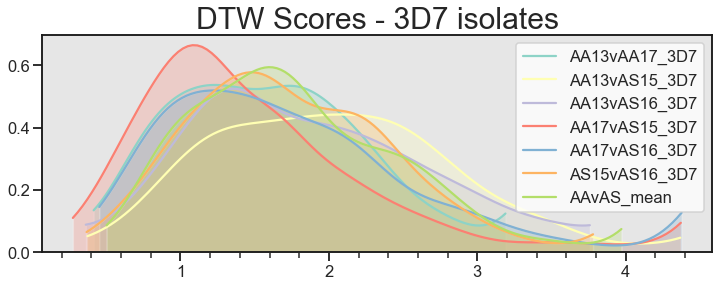

In [47]:
sns.set_palette("Set3")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": '.9', 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(12,4))
data = dtw_3D7
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='white')
plt.title('DTW Scores - 3D7 isolates', fontsize=30)

In [48]:
stats_3D7 = dtw_3D7.describe()
stats_3D7

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,1.564921,2.002199,1.871325,1.457001,1.655958,1.724608,1.746621
std,0.608434,0.772248,0.750206,0.744913,0.750618,0.643424,0.659921
min,0.414742,0.372815,0.361753,0.274667,0.452471,0.366894,0.501810
25%,1.080795,1.393390,1.306917,0.942867,1.056493,1.262342,1.237167
50%,1.535779,1.998474,1.793976,1.261099,1.555169,1.630757,1.667064
75%,2.019224,2.525489,2.375919,1.784133,2.099881,2.196025,2.195434
max,3.190126,4.368837,3.759052,4.372225,4.377633,3.780520,3.971782


In [49]:
thresh = (dtw_3D7['AAvAS_mean'].std() * 2) + dtw_3D7['AAvAS_mean'].mean()
print(thresh)
sigRing_3D7 = dtw_3D7[(dtw_3D7['AAvAS_mean'] > thresh)]
sigRing_3D7 = sigRing_3D7.sort_values(by = 'AAvAS_mean', ascending=False)
sigRing_3D7

3.0664622418180048


,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
ORF,,,,,,,
PF3D7_0935100,1.565500,4.228370,3.586871,4.326303,3.745585,2.557358,3.971782
PF3D7_0825600,2.801185,3.674383,3.750340,3.533609,3.293885,1.690425,3.563054
PF3D7_1015000,2.560362,4.368837,3.367132,3.472604,3.036389,2.040319,3.561241
PF3D7_1409200.2,2.518963,1.764795,3.632530,4.372225,4.377633,2.941078,3.536796
PF3D7_1249400,2.149447,2.790735,3.031894,3.844067,4.313443,2.251865,3.495035
PF3D7_1034600,1.766527,4.098885,2.917546,3.723724,2.806029,3.486326,3.386546
PF3D7_0219300,2.388860,4.021909,2.413337,3.930525,2.954537,2.842695,3.330077
PF3D7_1442000,2.463046,3.173971,2.234864,4.231010,3.476740,2.296600,3.279146
PF3D7_0411100,2.861232,3.559011,3.078268,2.450761,3.349086,2.434634,3.109281


Text(0.5, 1.0, 'DTW Scores - FUP isolates')

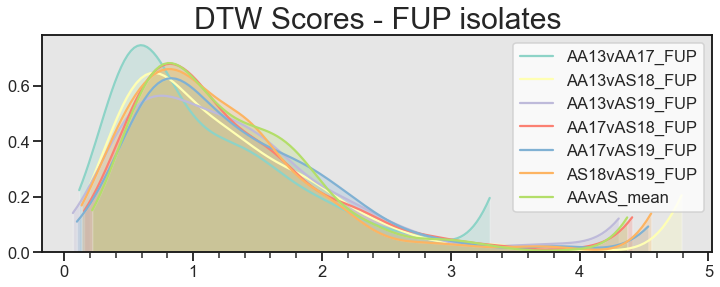

In [50]:
sns.set_palette("Set3")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": ".9", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(12,4))
data = dtw_FUP
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='white')
plt.title('DTW Scores - FUP isolates', fontsize=30)

In [51]:
thresh_ringFUP = (dtw_FUP['AAvAS_mean'].std() * 2) + dtw_FUP['AAvAS_mean'].mean()
print(thresh_ringFUP)
sigRing_FUP = dtw_FUP[(dtw_FUP['AAvAS_mean'] > thresh_ringFUP)]
sigRing_FUP = sigRing_FUP.sort_values(by = 'AAvAS_mean', ascending=False)
sigRing_FUP

2.566256365238151


,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean
ORF,,,,,,,
PF3D7_1331400,0.890324,4.791806,4.303806,4.408020,3.974286,1.945923,4.369480
PF3D7_1351600,0.564493,4.136548,3.888419,4.012199,3.785198,3.145651,3.955591
PF3D7_0613200,2.730936,2.915038,3.516654,4.123079,2.882274,2.815256,3.359261
PF3D7_0631600,3.010349,1.875373,3.946543,2.403173,4.532392,3.943393,3.189370
PF3D7_0611100,2.202789,3.368237,3.846735,3.100578,2.423565,3.733226,3.184779
PF3D7_0200800,1.540262,2.548002,3.442608,2.956793,3.114350,2.725785,3.015438
PF3D7_1319500,2.027250,1.975716,3.853068,2.255829,3.716977,4.555534,2.950397
PF3D7_1426900,1.715681,2.891390,3.431220,2.199369,3.030632,2.889419,2.888152
PF3D7_0317400,1.475229,3.338002,2.349025,3.389098,2.467255,2.106697,2.885845


In [52]:
dtw_takt_thresh_3D7 = set(sigRing_3D7.index.tolist())
dtw_takt_thresh_FUP = set(sigRing_FUP.index.tolist())

In [53]:
AA_3D7 = AA_3D7_df.loc[:,0:24]
AS_3D7 = AS_3D7_df.loc[:,0:24]
AA_FUP = AA_FUP_df.loc[:,0:18]
AS_FUP = AS_FUP_df.loc[:,0:18]

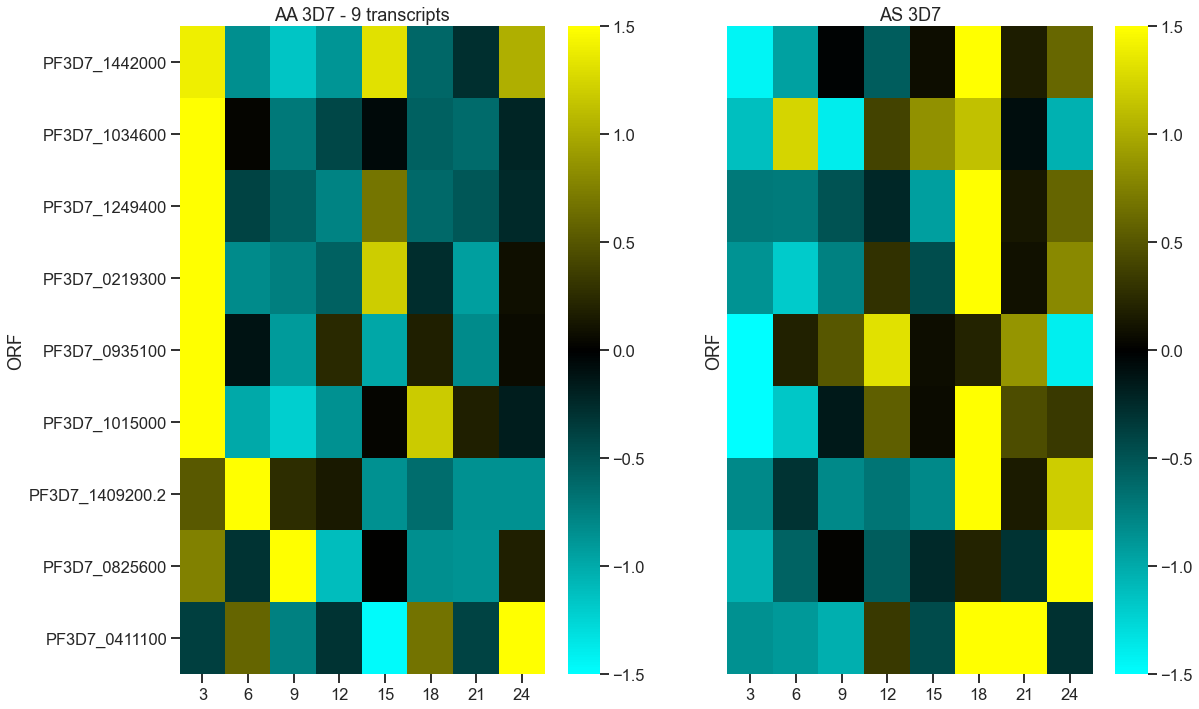

In [54]:
sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 12))
fig.patch.set_facecolor('w')
fig.patch.set_alpha(1)
genelist = dtw_takt_thresh_3D7
top_N = len(genelist)

aa_3d7_heat = heatmap_max(AA_3D7, genelist, 8, yticks=True, axis=ax1)
ax1.title.set_text('AA 3D7 - {} transcripts'.format(top_N))
as_3d7_heat = heatmap_order(AS_3D7, aa_3d7_heat.tolist(), axis=ax2)
ax2.title.set_text('AS 3D7'.format(top_N))

plt.subplots_adjust(top=0.875)

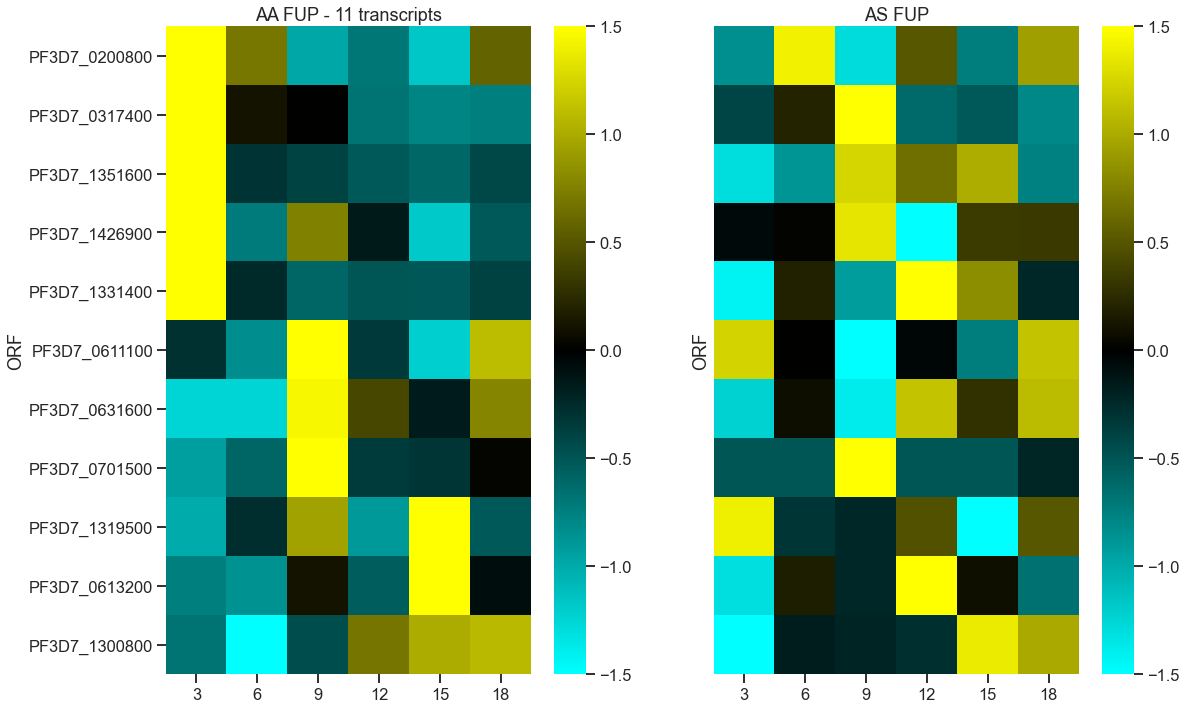

In [55]:
sns.set_context("talk")
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 12))
fig.patch.set_facecolor('w')
fig.patch.set_alpha(1)
genelist = dtw_takt_thresh_FUP
top_N = len(genelist)

aa_fup_heat = heatmap_max(AA_FUP, genelist, 8, yticks=True, axis=ax1)
ax1.title.set_text('AA FUP - {} transcripts'.format(top_N))
as_fup_heat = heatmap_order(AS_FUP, aa_fup_heat.tolist(), axis=ax2)
ax2.title.set_text('AS FUP'.format(top_N))

plt.subplots_adjust(top=0.875)